In [ ]:
!pip install raiutils

In [ ]:
!pip install fairlearn

# Loan Approval Fairness Analysis and Mitigation

This notebook demonstrates the process of analyzing and mitigating bias in a loan approval model. Our purpose is to predict whether or not a person will be approved for a loan. We'll use a logistic regression model and apply fairness constraints using the Fairlearn library to reduce demographic disparities in loan approvals across different racial groups.

In [27]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score
from fairlearn.metrics import demographic_parity_difference, false_positive_rate, true_positive_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import (
    MetricFrame,
    count,
    equalized_odds_difference,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from google.colab import drive
from google.colab import files

## Data Loading and Preprocessing

We'll start by loading the loan data and preprocessing it for our model, taking a look at the columns. This includes converting categorical variables to numerical.

In [28]:
data_path = '../data/credit_risk_test.csv'

In [29]:
# Load and preprocess the data
data = pd.read_csv(drive_path)

In [30]:
data.head()

,Loan_ID,Gender,Race,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,Caucasian,No,0,Graduate,No,5849,0.0,500,360,1,Urban,Y
1,LP001003,Male,African-American,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N
2,LP001005,Male,Native American,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
3,LP001006,Male,Native American,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y
4,LP001008,Male,Native American,No,0,Graduate,No,6000,0.0,141,360,1,Urban,Y


In [31]:
data.shape

(981, 14)

In [32]:
data.columns

Index(['Loan_ID', 'Gender', 'Race', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [33]:
# Convert categorical variables to numerical
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

## Data Splitting and Feature Scaling

Now we'll split our data into features (X) and target (y), then further split into training and testing sets. We'll also scale our features using StandardScaler.

In [34]:
# Split features and target
X = data.drop(['Loan_ID', 'Loan_Status_Y', 'Race'], axis=1)
y = data['Loan_Status_Y']
sensitive_features = data['Race']

In [35]:
data.head()

,Loan_ID,Race,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,LP001002,Caucasian,0,5849,0.0,500,360,1,True,False,False,False,False,True,True
1,LP001003,African-American,1,4583,1508.0,128,360,1,True,True,False,False,False,False,False
2,LP001005,Native American,0,3000,0.0,66,360,1,True,True,False,True,False,True,True
3,LP001006,Native American,0,2583,2358.0,120,360,1,True,True,True,False,False,True,True
4,LP001008,Native American,0,6000,0.0,141,360,1,True,False,False,False,False,True,True


In [36]:
data.shape

(981, 15)

In [37]:
data.Race.value_counts()

,count
Race,
Caucasian,293
Native American,177
Hispanic,156
African-American,149
Asian,139
Other,67


In [38]:
data.columns

Index(['Loan_ID', 'Race', 'Dependents', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Gender_Male',
       'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'Loan_Status_Y'],
      dtype='object')

In [39]:
# Split data into train and test sets
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(X, y, sensitive_features, test_size=0.2, random_state=42)


In [40]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Original Model Training and Evaluation

We'll train a logistic regression model on our data and evaluate its fairness metrics. We will focus on two key fairness metrics:

1. Demographic Parity Difference (DPD):
   - What it measures: The difference in selection rates between groups.
   - Calculation: Since this a binary classification problem (yes or no for loan approval), it's the difference between the proportion of positive predictions in the privileged group and the unprivileged group. In this experiment there isn't necessarily a privileged/unprivileged, it's calculated by every race versus each other.
   - Formula: DPD = P(Ŷ=1|A=privileged) - P(Ŷ=1|A=unprivileged)
     where Ŷ is the predicted outcome and A is the sensitive attribute (race in this case).
   - Interpretation: A value of 0 indicates perfect demographic parity. Positive values indicate the privileged group is favored, negative values indicate the unprivileged group is favored.
   - Why we use it: It helps identify if the model is making decisions that disproportionately affect certain racial groups, regardless of the true outcomes.

2. False Positive Rate (FPR):
   - What it measures: The proportion of negative instances that are incorrectly classified as positive.
   - Calculation: FPR = False Positives / (False Positives + True Negatives)
   - Interpretation: Usually the lower the values are the better. In the context of loan approval for bias mitigation, a high a high FPR across racial groups means everyone is being approved at the same rate.
   - Why we use it: In loan approval, comparing FPRs across groups helps identify if the model is more prone to making this type of error for certain racial groups.

By examining these metrics for each racial category, we can assess whether our model is behaving fairly across different groups. Significant disparities in these metrics across racial categories would indicate potential bias in the model's decisions.

It's important to note that with most bias mitigation it's a balancing act between accuracy and fairness. It is up to the organization to decide on what the threshold should be.

In [41]:
# Create and train the original model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [42]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [44]:
# Calculate fairness metrics for the original model
dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sf_test)
print(f"Demographic Parity Difference: {dpd}")

Demographic Parity Difference: 0.31593406593406603


In [45]:
for race in np.unique(sf_test):
    mask = sf_test == race
    fpr = false_positive_rate(y_test[mask], y_pred[mask])
    print(f"False Positive Rate for {race}: {fpr}")

False Positive Rate for African-American: 0.6
False Positive Rate for Asian: 0.42105263157894735
False Positive Rate for Caucasian: 0.42857142857142855
False Positive Rate for Hispanic: 0.6
False Positive Rate for Native American: 0.5714285714285714
False Positive Rate for Other: 0.6666666666666666


## Bias Mitigation using ExponentiatedGradient

Now we'll apply Fairlearn's ExponentiatedGradient algorithm with a DemographicParity constraint to mitigate bias in our model. It *is* possible to have multiple contraints.

ExponentiatedGradient Algorithm:
- This is an optimization algorithm used to find a fair model that satisfies specified fairness constraints.
- It works by training multiple models with different weights for each sample, iteratively adjusting these weights to satisfy the fairness constraint while maintaining predictive performance.
- The algorithm aims to find a randomized classifier (a probability distribution over a set of classifiers) that satisfies the fairness constraints in expectation.

DemographicParity Constraint:
-  This constraint aims to ensure that the prediction of the positive outcome (loan approval) should be equal across all demographic groups. In the context of loan approvals, it means that the proportion of approved loans should be approximately equal across all racial groups.

The ExponentiatedGradient algorithm will attempt to find a model that satisfies this constraint while minimizing loss in predictive performance.



In [46]:
#set seed for consistent results with ExponentiatedGradient
np.random.seed(43)

# Apply Fairlearn's ExponentiatedGradient for bias mitigation
constraint = DemographicParity()
mitigator = ExponentiatedGradient(LogisticRegression(random_state=42), constraints=constraint)
mitigated_model = mitigator.fit(X_train_scaled, y_train, sensitive_features=sf_train)

In [47]:
# Make predictions with the mitigated model
y_pred_mitigated = mitigated_model.predict(X_test_scaled)

In [48]:
# Calculate fairness metrics for the mitigated model

dpd_mitigated = demographic_parity_difference(y_test, y_pred_mitigated, sensitive_features=sf_test)
print(f"Mitigated Demographic Parity Difference: {dpd_mitigated}")

Mitigated Demographic Parity Difference: 0.0357142857142857


In [50]:
for race in np.unique(sf_test):
    mask = sf_test == race
    fpr_mitigated = false_positive_rate(y_test[mask], y_pred_mitigated[mask])
    print(f"Mitigated False Positive Rate for {race}: {fpr_mitigated}")

Mitigated False Positive Rate for African-American: 0.9333333333333333
Mitigated False Positive Rate for Asian: 0.9473684210526315
Mitigated False Positive Rate for Caucasian: 1.0
Mitigated False Positive Rate for Hispanic: 0.8
Mitigated False Positive Rate for Native American: 1.0
Mitigated False Positive Rate for Other: 1.0


## Our analysis for original metrics versus mitigated metrics


Our demographic parity is essentially looking at the selection rate between racial groups.
In this context, the "selection rate" refers to the proportion of individuals in each group who are approved for a loan according to the model's predictions. More specifically:

A "selection" (or positive prediction) is when the model predicts that a loan should be approved (y_pred = 1).
The selection rate for a group is the number of approved loans divided by the total number of applicants in that group.


- Demographic Parity Difference (DPD):

 - Before mitigation: 0.315
 - After mitigation: 0.0357

Before mitigation:

- The maximum difference in selection rates between any two racial groups was 0.315 or 31.5%.
For example, if the group with the highest approval rate had 50% of its applicants approved, the group with the lowest rate might have had only 18.5% approved (50% - 31.5% = 18.5%).
This indicates a significant disparity in loan approval rates across racial groups.


After mitigation:

- The maximum difference reduced to 0.0357 or 3.57%.
Using the same example, if one group had a 50% approval rate, the group with the lowest rate would now have about 46.43% approved.
This shows a substantial reduction in the disparity of approval rates across racial groups.



What we can deduce is that before mitigation:

- There was a large gap in approval rates between the most-favored and least-favored racial groups.
Some racial groups were much more likely to be approved for loans than others.

- For the false postive rate there was an uneven rate across groups of people who received loans that should not have.

And after mitigation:

 - The approval rates across all racial groups became similar.
The chance of getting a loan approval is now much more consistent across racial groups.

- The false postive rate is much more consistant now. Now everyone gets a loan. This of course is not accurate and very risky, but it's more consistent.

Mitigation has significantly reduced the disparity in loan approval rates across racial groups, which is the goal of achieving demographic parity. However, it's important to note:

This doesn't necessarily mean the model is making better predictions overall. It's possible that accuracy was traded for fairness.
Other fairness metrics (like equal opportunity or equalized odds) might still show disparities.
The underlying reasons for the original disparity should still be investigated, as they might reflect important factors in loan decisions or potential biases in the training data.

In [51]:
# dictionary of metrics
original_fpr = {
    'African-American': 0.6,
    'Asian': 0.42105263157894735,
    'Caucasian': 0.42857142857142855,
    'Hispanic': 0.6,
    'Native American': 0.5714285714285714,
    'Other': 0.6666666666666666
}

mitigated_fpr = {
    'African-American': 0.9333333333333333,
    'Asian': 0.9473684210526315,
    'Caucasian': 1.0,
    'Hispanic': 0.8,
    'Native American': 1.0,
    'Other': 1.0
}


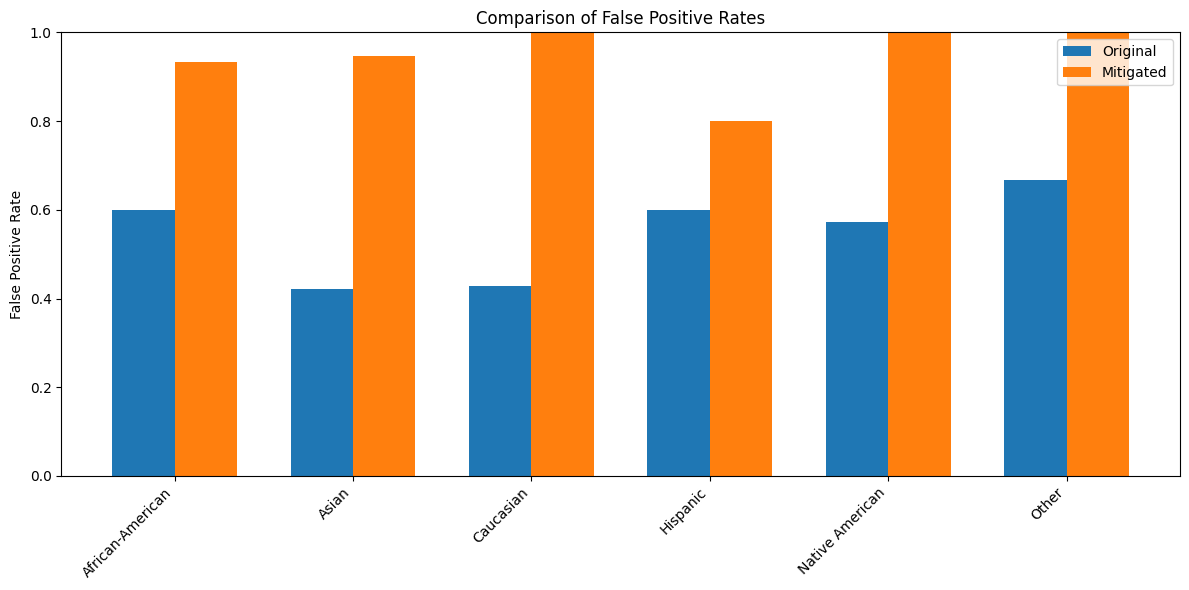

In [52]:
import matplotlib.pyplot as plt
def plot_grouped_false_positive_rates(original_fpr, mitigated_fpr):
    groups = list(original_fpr.keys())

    x = range(len(groups))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar([i - width/2 for i in x], original_fpr.values(), width, label='Original')
    ax.bar([i + width/2 for i in x], mitigated_fpr.values(), width, label='Mitigated')

    ax.set_ylabel('False Positive Rate')
    ax.set_title('Comparison of False Positive Rates')
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

plot_grouped_false_positive_rates(original_fpr, mitigated_fpr)

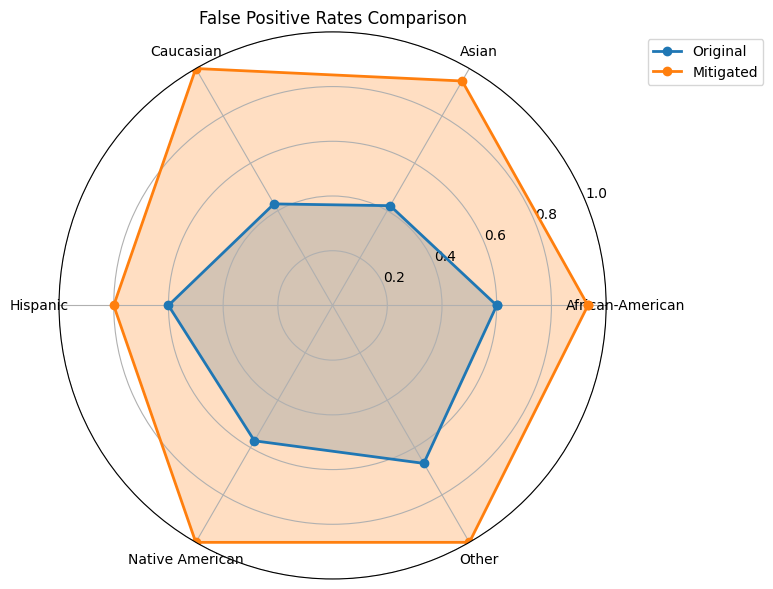

In [53]:
def plot_radar_chart(original_fpr, mitigated_fpr):
    groups = list(original_fpr.keys())

    angles = np.linspace(0, 2*np.pi, len(groups), endpoint=False)

    original_values = list(original_fpr.values())
    mitigated_values = list(mitigated_fpr.values())

    original_values.append(original_values[0])
    mitigated_values.append(mitigated_values[0])
    angles = np.concatenate((angles, [angles[0]]))

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    ax.plot(angles, original_values, 'o-', linewidth=2, label='Original')
    ax.fill(angles, original_values, alpha=0.25)
    ax.plot(angles, mitigated_values, 'o-', linewidth=2, label='Mitigated')
    ax.fill(angles, mitigated_values, alpha=0.25)

    ax.set_thetagrids(angles[:-1] * 180/np.pi, groups)
    ax.set_ylim(0, 1)
    ax.set_title('False Positive Rates Comparison')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.show()

plot_radar_chart(original_fpr, mitigated_fpr)

In [54]:
import matplotlib.pyplot as plt

def plot_grouped_false_positive_rates(original_fpr, mitigated_fpr):
    groups = list(original_fpr.keys())
    x = range(len(groups))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    original_bars = ax.bar([i - width/2 for i in x], original_fpr.values(), width, label='Original')
    mitigated_bars = ax.bar([i + width/2 for i in x], mitigated_fpr.values(), width, label='Mitigated')

    ax.set_ylabel('False Positive Rate')
    ax.set_title('Comparison of False Positive Rates')
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.1)  # Increased y-limit to accommodate labels

    # Function to add value labels
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', rotation=0)

    add_value_labels(original_bars)
    add_value_labels(mitigated_bars)

    plt.tight_layout()
    plt.show()

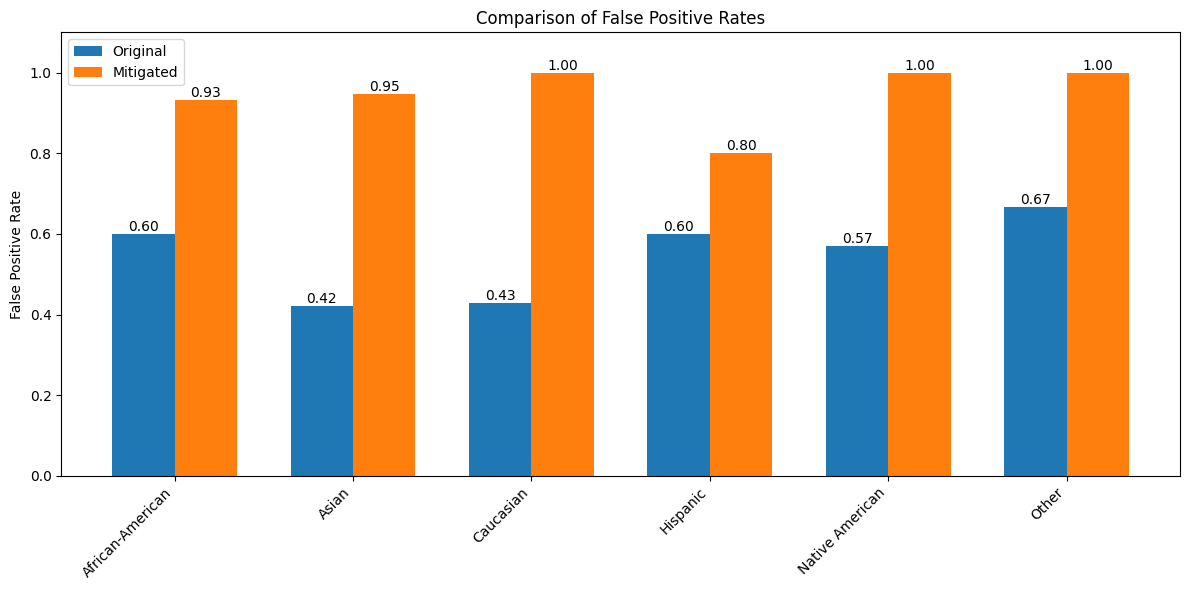

In [55]:
plot_grouped_false_positive_rates(original_fpr, mitigated_fpr)